# 02 — Player 360: EDA & Feature Engineering

## From Raw Events to Actionable Player Profiles

In a production environment, PlayStation's data warehouse contains billions of raw events —
every session, every purchase, every trophy unlock. But models don't train on raw events.
They train on **player-level features** that compress months of behaviour into a single row
per player: a 'Player 360' view.

This notebook does two things:

**1. Exploratory Analysis** — We examine the data through a business lens, focusing on the
patterns that matter for churn prediction and propensity modelling. Not 50 charts for the sake
of it — just the 5-6 visualisations that directly inform our modelling decisions.

**2. Feature Engineering** — We build the Player 360 feature table: one row per player, with
features spanning engagement, monetary value, subscription behaviour, trophy depth, and DLC
interaction. This single table feeds every model in the project.

### Feature Categories

| Category | Examples | Why It Matters |
|----------|----------|----------------|
| **Engagement** | Session frequency, recency, duration trends | Declining engagement is the earliest churn signal |
| **Monetary** | Total spend, spend velocity, MTX behaviour | Revenue history is the core of CLV |
| **Subscription** | Tier, billing cycle, auto-renew, tenure | Structural commitment indicators |
| **Trophy** | Earn rate, platinum count, recent trophy activity | Depth of engagement beyond just 'time spent' |
| **DLC** | Free DLC claims, paid DLC purchases, Valhalla flag | Content engagement predicts future purchases |
| **Behavioural Trends** | Session slope, spend acceleration, engagement velocity | Direction matters more than level |

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

# Plotting style
sns.set_theme(style="whitegrid", palette="deep")
plt.rcParams["figure.figsize"] = (12, 5)
plt.rcParams["figure.dpi"] = 100

DATA_DIR = Path("data")

# Load all tables
players = pd.read_csv(DATA_DIR / "players.csv", parse_dates=["signup_date"])
subs = pd.read_csv(DATA_DIR / "subscriptions.csv", parse_dates=["start_date", "end_date"])
sessions = pd.read_csv(DATA_DIR / "sessions.csv", parse_dates=["session_date"])
purchases = pd.read_csv(DATA_DIR / "purchases.csv", parse_dates=["purchase_date"])
trophies = pd.read_csv(DATA_DIR / "trophies.csv", parse_dates=["trophy_date"])
games = pd.read_csv(DATA_DIR / "games.csv", parse_dates=["release_date"])
dlc_cat = pd.read_csv(DATA_DIR / "dlc_catalog.csv", parse_dates=["release_date"])
archetype_key = pd.read_csv(DATA_DIR / "_archetype_key.csv")  # For validation only

# Reference date: end of observation window
REFERENCE_DATE = pd.Timestamp("2025-12-31")

print(f"Players:       {len(players):>8,}")
print(f"Subscriptions: {len(subs):>8,}")
print(f"Sessions:      {len(sessions):>8,}")
print(f"Purchases:     {len(purchases):>8,}")
print(f"Trophies:      {len(trophies):>8,}")

Players:          5,000
Subscriptions:    5,000
Sessions:       809,870
Purchases:       13,430
Trophies:       158,707


---
# Part 1: Exploratory Analysis

We focus on patterns that directly inform modelling decisions.

### 1. The Subscription Landscape

Understanding the tier distribution and churn rates tells us about class balance
(critical for model training) and where the business risk concentrates.

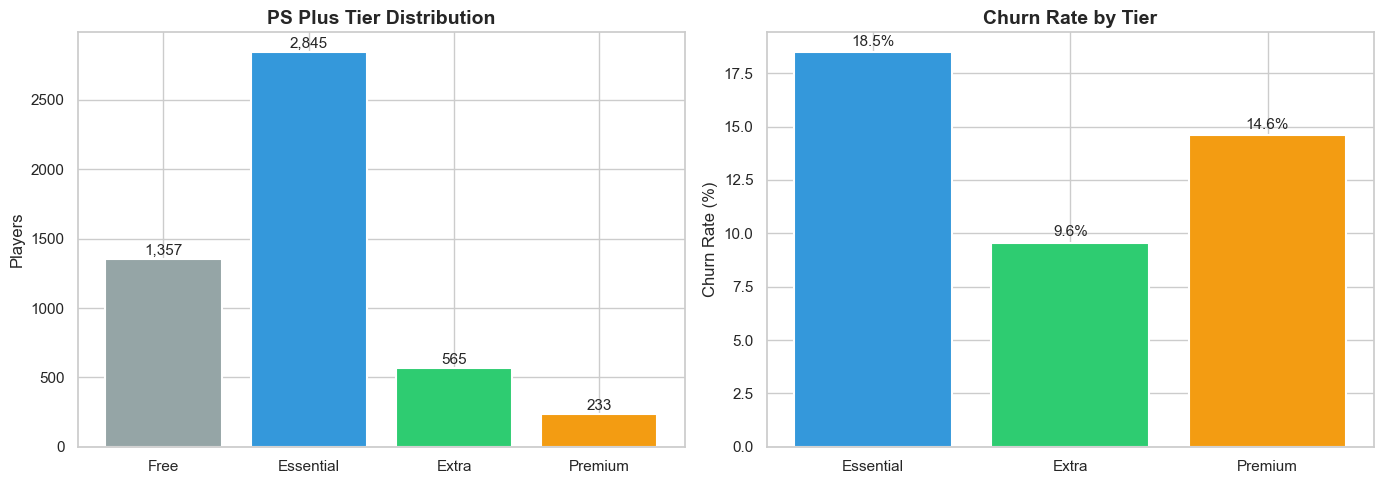

Overall paid churn rate: 16.9%
Free tier players: 1,357 — these are propensity targets for upgrade


In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Tier distribution
tier_order = ["Free", "Essential", "Extra", "Premium"]
tier_counts = subs["tier"].value_counts().reindex(tier_order)
colors = ["#95a5a6", "#3498db", "#2ecc71", "#f39c12"]
bars = axes[0].bar(tier_order, tier_counts.values, color=colors, edgecolor="white", linewidth=1.5)
axes[0].set_title("PS Plus Tier Distribution", fontsize=14, fontweight="bold")
axes[0].set_ylabel("Players")
for bar, val in zip(bars, tier_counts.values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 30,
                f"{val:,}", ha="center", fontsize=11)

# Right: Churn rate by tier
churn_by_tier = subs[subs["tier"] != "Free"].groupby("tier")["is_active"].apply(
    lambda x: (~x).mean()
).reindex(["Essential", "Extra", "Premium"])
bar_colors = ["#3498db", "#2ecc71", "#f39c12"]
bars2 = axes[1].bar(churn_by_tier.index, churn_by_tier.values * 100, color=bar_colors,
                     edgecolor="white", linewidth=1.5)
axes[1].set_title("Churn Rate by Tier", fontsize=14, fontweight="bold")
axes[1].set_ylabel("Churn Rate (%)")
for bar, val in zip(bars2, churn_by_tier.values):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
                f"{val:.1%}", ha="center", fontsize=11)

plt.tight_layout()
plt.show()

# Key stat
paid_subs = subs[subs["tier"] != "Free"]
print(f"Overall paid churn rate: {(~paid_subs['is_active']).mean():.1%}")
print(f"Free tier players: {(subs['tier'] == 'Free').sum():,} — these are propensity targets for upgrade")

### 2. The Anatomy of Churn: Session Decay Before Cancellation

This is the most important chart for the churn model. If engagement drops predictably
before cancellation, our model can detect at-risk players *before* they leave —
when intervention still matters.

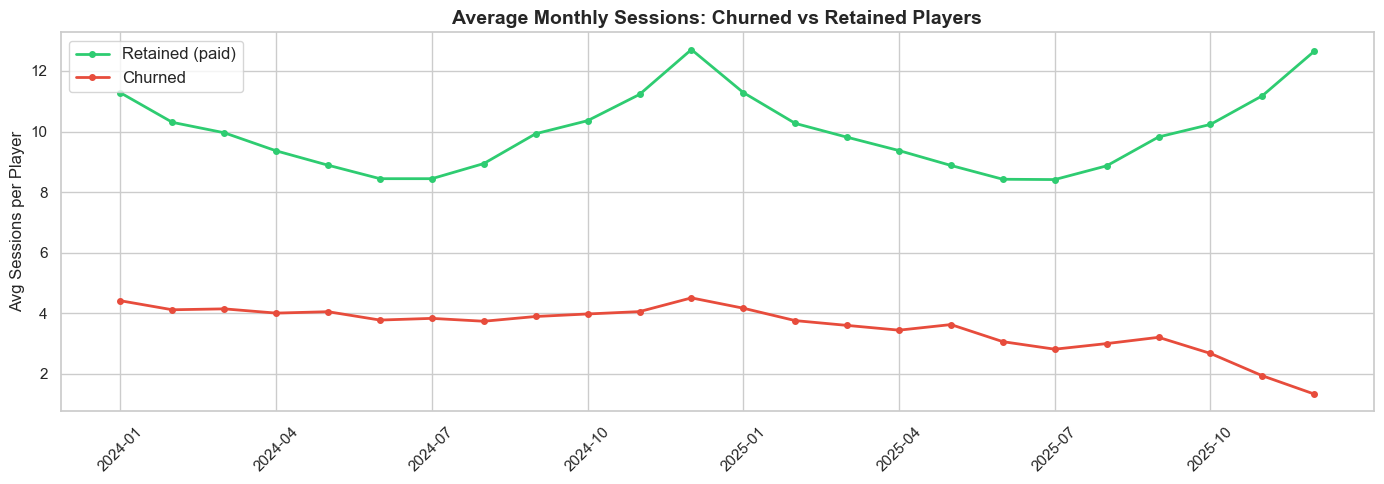

Key insight: Churned players show a clear downward trend in the months before cancellation.
This decay pattern means we can engineer trend-based features that capture disengagement early.


In [6]:
# Compare monthly session trends: churned vs retained players
churned_ids = set(subs[~subs["is_active"]]["player_id"])
retained_ids = set(subs[subs["is_active"] & (subs["tier"] != "Free")]["player_id"])

sessions["year_month"] = sessions["session_date"].dt.to_period("M")

# Monthly sessions per player, then average by group
monthly_player = sessions.groupby(["player_id", "year_month"]).size().reset_index(name="n_sessions")

churned_monthly = monthly_player[monthly_player["player_id"].isin(churned_ids)].groupby(
    "year_month")["n_sessions"].mean()
retained_monthly = monthly_player[monthly_player["player_id"].isin(retained_ids)].groupby(
    "year_month")["n_sessions"].mean()

fig, ax = plt.subplots(figsize=(14, 5))
x_churned = [str(p) for p in churned_monthly.index]
x_retained = [str(p) for p in retained_monthly.index]
ax.plot(x_retained, retained_monthly.values, marker="o", markersize=4,
        linewidth=2, label="Retained (paid)", color="#2ecc71")
ax.plot(x_churned, churned_monthly.values, marker="o", markersize=4,
        linewidth=2, label="Churned", color="#e74c3c")
ax.set_title("Average Monthly Sessions: Churned vs Retained Players",
             fontsize=14, fontweight="bold")
ax.set_ylabel("Avg Sessions per Player")
ax.set_xlabel("")
# Show every 3rd label to avoid crowding
tick_labels = [str(p) for p in retained_monthly.index]
ax.set_xticks(range(0, len(tick_labels), 3))
ax.set_xticklabels([tick_labels[i] for i in range(0, len(tick_labels), 3)], rotation=45)
ax.legend(fontsize=12)
plt.tight_layout()
plt.show()

print("Key insight: Churned players show a clear downward trend in the months before cancellation.")
print("This decay pattern means we can engineer trend-based features that capture disengagement early.")

### 3. Revenue Concentration: The Whale Effect

In most gaming businesses, a small fraction of players generate the majority of revenue.
Understanding this distribution is essential for CLV modelling — predicting *who* the
high-value players are is worth far more than predicting average behaviour.

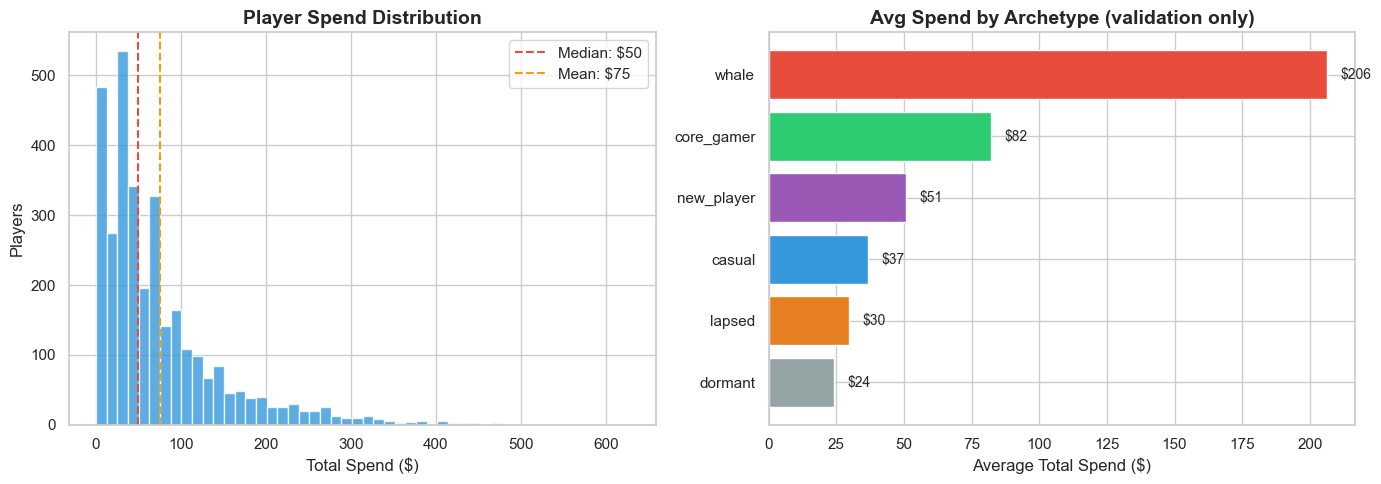

Top 10% of spenders account for 34% of total revenue
This concentration is why CLV modelling matters — identifying and retaining high-value players
is disproportionately important.


In [7]:
player_spend = purchases.groupby("player_id")["amount"].sum().reset_index()
player_spend.columns = ["player_id", "total_spend"]

# Add archetype for validation
player_spend = player_spend.merge(archetype_key, on="player_id", how="left")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Spend distribution (log scale)
axes[0].hist(player_spend["total_spend"], bins=50, color="#3498db", edgecolor="white", alpha=0.8)
axes[0].set_title("Player Spend Distribution", fontsize=14, fontweight="bold")
axes[0].set_xlabel("Total Spend ($)")
axes[0].set_ylabel("Players")
axes[0].axvline(player_spend["total_spend"].median(), color="#e74c3c", linestyle="--",
               label=f'Median: ${player_spend["total_spend"].median():.0f}')
axes[0].axvline(player_spend["total_spend"].mean(), color="#f39c12", linestyle="--",
               label=f'Mean: ${player_spend["total_spend"].mean():.0f}')
axes[0].legend()

# Right: Average spend by archetype (validation view)
arch_spend = player_spend.groupby("archetype")["total_spend"].mean().sort_values(ascending=True)
arch_colors = {"dormant": "#95a5a6", "lapsed": "#e67e22", "casual": "#3498db",
               "new_player": "#9b59b6", "core_gamer": "#2ecc71", "whale": "#e74c3c"}
bar_colors = [arch_colors.get(a, "#333") for a in arch_spend.index]
axes[1].barh(arch_spend.index, arch_spend.values, color=bar_colors, edgecolor="white")
axes[1].set_title("Avg Spend by Archetype (validation only)", fontsize=14, fontweight="bold")
axes[1].set_xlabel("Average Total Spend ($)")
for i, (val, name) in enumerate(zip(arch_spend.values, arch_spend.index)):
    axes[1].text(val + 5, i, f"${val:.0f}", va="center", fontsize=10)

plt.tight_layout()
plt.show()

# Revenue concentration
sorted_spend = player_spend["total_spend"].sort_values(ascending=False)
top_10_pct = sorted_spend.head(int(len(sorted_spend) * 0.1)).sum()
total_rev = sorted_spend.sum()
print(f"Top 10% of spenders account for {top_10_pct/total_rev:.0%} of total revenue")
print(f"This concentration is why CLV modelling matters — identifying and retaining high-value players")
print(f"is disproportionately important.")

### 4. The Valhalla Effect: Free DLC as a Purchase Signal

God of War: Ragnarok's Valhalla DLC was released for free. The hypothesis:
**players who engage with free DLC are signalling deeper game commitment,
making them more receptive to paid content.** Let's see if the data supports this.

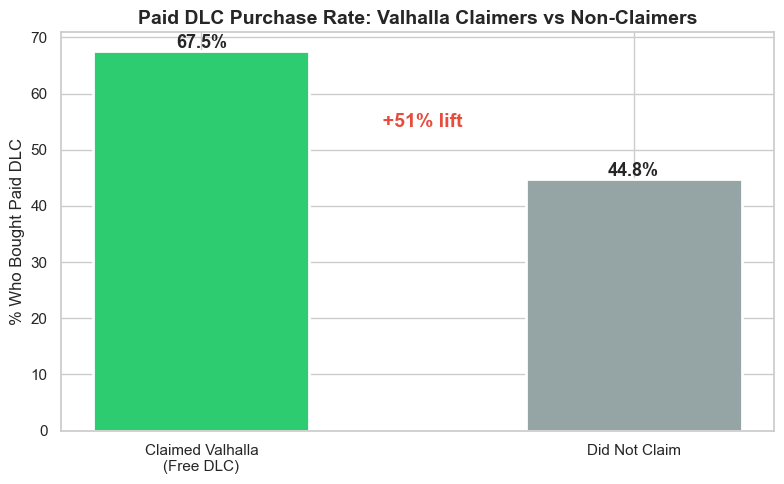

Valhalla claimers: 496 players
Paid DLC conversion: claimers=67.5% vs non-claimers=44.8%

This is a strong propensity signal. Free DLC engagement should be a feature in our model.


In [8]:
# Valhalla claimers vs non-claimers: paid DLC conversion rate
valhalla_claimers = set(purchases[purchases["item_id"] == "D001"]["player_id"])
paid_dlc_buyers = set(purchases[purchases["item_type"] == "dlc_paid"]["player_id"])
all_players = set(purchases["player_id"])

# Conversion rates
claimers_converted = len(valhalla_claimers & paid_dlc_buyers) / max(1, len(valhalla_claimers))
non_claimers = all_players - valhalla_claimers
non_converted = len(non_claimers & paid_dlc_buyers) / max(1, len(non_claimers))

fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(["Claimed Valhalla\n(Free DLC)", "Did Not Claim"],
              [claimers_converted * 100, non_converted * 100],
              color=["#2ecc71", "#95a5a6"], edgecolor="white", linewidth=2, width=0.5)
ax.set_title("Paid DLC Purchase Rate: Valhalla Claimers vs Non-Claimers",
             fontsize=14, fontweight="bold")
ax.set_ylabel("% Who Bought Paid DLC")
for bar, val in zip(bars, [claimers_converted, non_converted]):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
            f"{val:.1%}", ha="center", fontsize=13, fontweight="bold")

# Add lift annotation
if non_converted > 0:
    lift = (claimers_converted - non_converted) / non_converted
    ax.annotate(f"  {lift:+.0%} lift", xy=(0.5, max(claimers_converted, non_converted) * 100 * 0.8),
               fontsize=14, fontweight="bold", color="#e74c3c", ha="center")

plt.tight_layout()
plt.show()

print(f"Valhalla claimers: {len(valhalla_claimers):,} players")
print(f"Paid DLC conversion: claimers={claimers_converted:.1%} vs non-claimers={non_converted:.1%}")
print(f"\nThis is a strong propensity signal. Free DLC engagement should be a feature in our model.")

### 5. Auto-Renew: The Strongest Single Churn Predictor

Before building complex models, it's worth checking: is there a single feature that
already separates churners from retained players? In subscription businesses, auto-renew
status is often that feature.

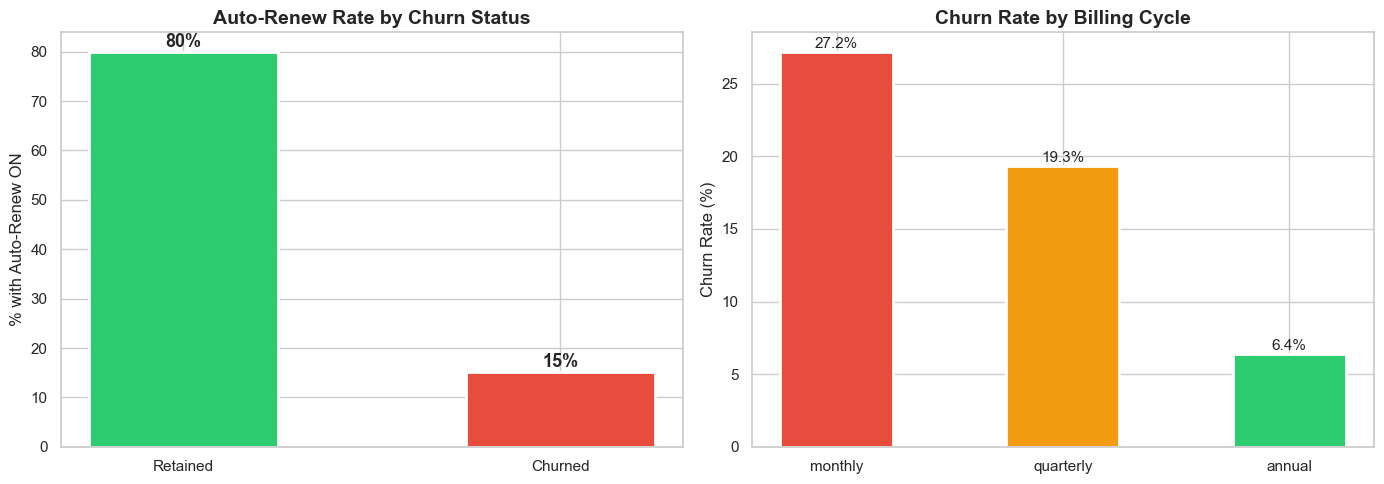

Both features are strong churn predictors on their own.
But the real power comes from combining them with behavioural signals in a model.


In [12]:
paid = subs[subs["tier"] != "Free"].copy()
paid["churned"] = ~paid["is_active"]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Auto-renew by churn status
ar_rates = paid.groupby("churned")["auto_renew"].mean() * 100
bars = axes[0].bar(["Retained", "Churned"], ar_rates.values,
                   color=["#2ecc71", "#e74c3c"], edgecolor="white", linewidth=2, width=0.5)
axes[0].set_title("Auto-Renew Rate by Churn Status", fontsize=14, fontweight="bold")
axes[0].set_ylabel("% with Auto-Renew ON")
for bar, val in zip(bars, ar_rates.values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f"{val:.0f}%", ha="center", fontsize=13, fontweight="bold")

# Right: Churn rate by billing cycle
churn_by_cycle = paid.groupby("billing_cycle")["churned"].mean().reindex(
    ["monthly", "quarterly", "annual"]) * 100
bars2 = axes[1].bar(churn_by_cycle.index, churn_by_cycle.values,
                    color=["#e74c3c", "#f39c12", "#2ecc71"], edgecolor="white", linewidth=2, width=0.5)
axes[1].set_title("Churn Rate by Billing Cycle", fontsize=14, fontweight="bold")
axes[1].set_ylabel("Churn Rate (%)")
for bar, val in zip(bars2, churn_by_cycle.values):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
                f"{val:.1f}%", ha="center", fontsize=11)

plt.tight_layout()
plt.show()

print("Both features are strong churn predictors on their own.")
print("But the real power comes from combining them with behavioural signals in a model.")

### 6. Seasonal Engagement Patterns

Understanding when players are most active helps contextualise engagement metrics —
a dip in July is seasonal, but a dip in December is a red flag.

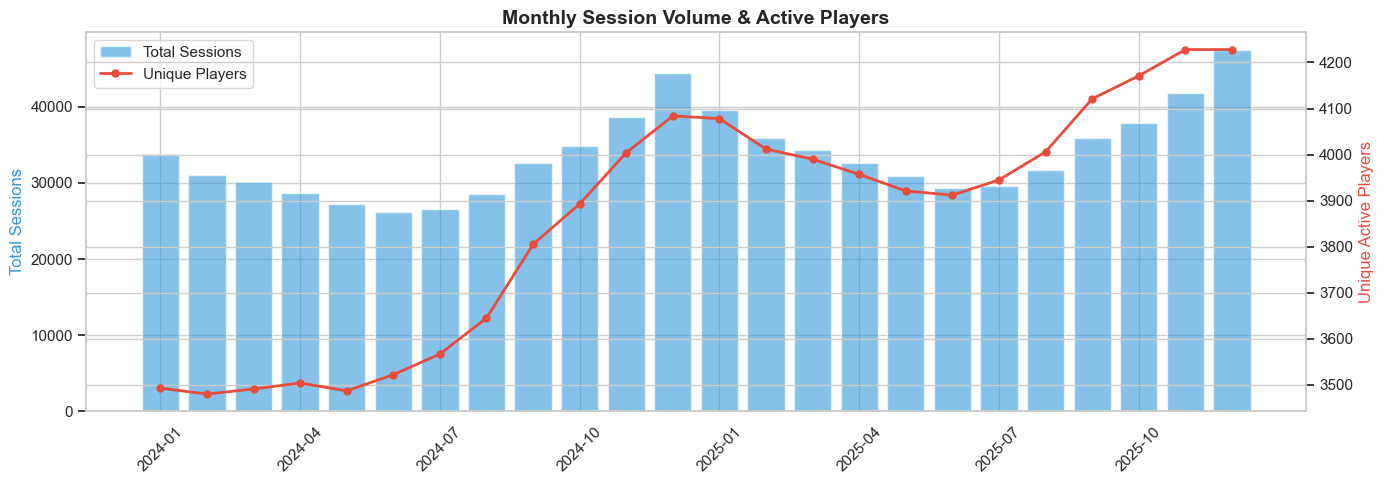

Holiday spikes (Dec) and summer dips (Jun-Jul) are visible.
Features must be normalised for seasonality, or use relative trends rather than absolute levels.


In [13]:
monthly_sessions = sessions.groupby(
    sessions["session_date"].dt.to_period("M")
).agg(
    total_sessions=("player_id", "size"),
    unique_players=("player_id", "nunique"),
    avg_duration=("duration_minutes", "mean"),
).reset_index()
monthly_sessions["session_date"] = monthly_sessions["session_date"].astype(str)

fig, ax1 = plt.subplots(figsize=(14, 5))

ax1.bar(monthly_sessions["session_date"], monthly_sessions["total_sessions"],
        color="#3498db", alpha=0.6, label="Total Sessions")
ax1.set_ylabel("Total Sessions", color="#3498db", fontsize=12)
ax1.set_title("Monthly Session Volume & Active Players", fontsize=14, fontweight="bold")

ax2 = ax1.twinx()
ax2.plot(monthly_sessions["session_date"], monthly_sessions["unique_players"],
         color="#e74c3c", marker="o", markersize=5, linewidth=2, label="Unique Players")
ax2.set_ylabel("Unique Active Players", color="#e74c3c", fontsize=12)

# Show every 3rd label
ax1.set_xticks(range(0, len(monthly_sessions), 3))
ax1.set_xticklabels(monthly_sessions["session_date"].iloc[::3], rotation=45)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left", fontsize=11)

plt.tight_layout()
plt.show()

print("Holiday spikes (Dec) and summer dips (Jun-Jul) are visible.")
print("Features must be normalised for seasonality, or use relative trends rather than absolute levels.")

---
# Part 2: Feature Engineering — Building the Player 360

We now compress all raw events into a single player-level feature table.
Every feature is engineered with a specific modelling purpose in mind.

**Time-aware design**: Features are calculated relative to the reference date (end of
observation window). 'Last 30 days', 'last 90 days', etc. ensure we're capturing
recency — the most predictive dimension in behavioural data.

**Trend features**: A player's *current level* of activity matters less than the
*direction*. Someone with 10 sessions/month who's declining is higher risk than someone
with 5 sessions/month who's stable. We compute engagement slopes to capture this.

### Subscription Features

Structural attributes of the player's relationship with PS Plus.

In [14]:
sub_features = subs[["player_id", "tier", "is_active", "auto_renew", "billing_cycle", "start_date"]].copy()

# Tenure in months
sub_features["tenure_months"] = (
    (REFERENCE_DATE - sub_features["start_date"]).dt.days / 30.44
).round(1)

# Encode tier as ordinal (useful for some models)
tier_map = {"Free": 0, "Essential": 1, "Extra": 2, "Premium": 3}
sub_features["tier_ordinal"] = sub_features["tier"].map(tier_map)

# Boolean flags
sub_features["is_paid_subscriber"] = sub_features["tier"] != "Free"
sub_features["is_auto_renew"] = sub_features["auto_renew"].astype(int)

# Billing cycle encoding
cycle_map = {"none": 0, "monthly": 1, "quarterly": 2, "annual": 3}
sub_features["billing_cycle_ordinal"] = sub_features["billing_cycle"].map(cycle_map)

sub_features = sub_features.drop(columns=["start_date", "auto_renew", "is_active", "billing_cycle"])
print(f"Subscription features: {sub_features.shape}")
sub_features.head()

Subscription features: (5000, 7)


,player_id,tier,tenure_months,tier_ordinal,is_paid_subscriber,is_auto_renew,billing_cycle_ordinal
0,PSN-00000,Essential,15.4,1,True,1,1
1,PSN-00001,Free,30.7,0,False,0,0
2,PSN-00002,Essential,68.6,1,True,0,1
3,PSN-00003,Essential,6.5,1,True,0,1
4,PSN-00004,Essential,12.6,1,True,1,3


### Engagement Features (Sessions)

Session data gives us recency, frequency, intensity, and trend — the four dimensions
of engagement that matter most for predicting churn.

In [15]:
# Overall session stats per player
session_agg = sessions.groupby("player_id").agg(
    total_sessions=("session_date", "count"),
    total_play_minutes=("duration_minutes", "sum"),
    avg_session_duration=("duration_minutes", "mean"),
    unique_games_played=("game_id", "nunique"),
    last_session_date=("session_date", "max"),
    first_session_date=("session_date", "min"),
).reset_index()

# Recency: days since last session
session_agg["days_since_last_session"] = (
    REFERENCE_DATE - session_agg["last_session_date"]
).dt.days

# Recent activity windows
for window_days, label in [(30, "30d"), (90, "90d"), (180, "180d")]:
    cutoff = REFERENCE_DATE - pd.Timedelta(days=window_days)
    recent = sessions[sessions["session_date"] >= cutoff].groupby("player_id").agg(
        **{f"sessions_{label}": ("session_date", "count"),
           f"play_minutes_{label}": ("duration_minutes", "sum")}
    ).reset_index()
    session_agg = session_agg.merge(recent, on="player_id", how="left")

# Fill NaN (players with no activity in a window) with 0
session_agg = session_agg.fillna(0)

# Drop raw date columns
session_agg = session_agg.drop(columns=["last_session_date", "first_session_date"])

print(f"Session features: {session_agg.shape}")
session_agg.head()

Session features: (4547, 12)


,player_id,total_sessions,total_play_minutes,avg_session_duration,unique_games_played,days_since_last_session,sessions_30d,play_minutes_30d,sessions_90d,play_minutes_90d,sessions_180d,play_minutes_180d
0,PSN-00000,29,906,31.241379,1,8,2.0,83.0,5.0,171.0,10.0,367.0
1,PSN-00001,156,5184,33.230769,3,3,7.0,283.0,21.0,786.0,37.0,1298.0
2,PSN-00003,13,326,25.076923,1,163,0.0,0.0,0.0,0.0,1.0,25.0
3,PSN-00004,129,4788,37.116279,11,3,15.0,776.0,37.0,1612.0,63.0,2522.0
4,PSN-00005,172,8906,51.779070,2,1,19.0,1301.0,49.0,2989.0,84.0,4442.0


### Engagement Trend Features

The *direction* of engagement matters more than the *level*. We compute the slope of
monthly session counts over recent months. A negative slope = disengaging.

In [16]:
# Monthly session counts per player
sessions["year_month_num"] = (
    sessions["session_date"].dt.year * 12 + sessions["session_date"].dt.month
)

monthly_player_sessions = sessions.groupby(
    ["player_id", "year_month_num"]
).size().reset_index(name="monthly_sessions")

def compute_session_slope(group):
    """Compute linear regression slope of monthly sessions (last 6 months)."""
    # Filter to last 6 months
    max_month = group["year_month_num"].max()
    recent = group[group["year_month_num"] > max_month - 6]
    if len(recent) < 3:  # Need at least 3 data points
        return 0.0
    x = recent["year_month_num"].values - recent["year_month_num"].min()
    y = recent["monthly_sessions"].values
    # Simple linear regression slope
    if x.std() == 0:
        return 0.0
    slope = np.polyfit(x, y, 1)[0]
    return round(slope, 3)

print("Computing session trends (this may take a minute)...")
session_slopes = monthly_player_sessions.groupby("player_id").apply(
    compute_session_slope
).reset_index(name="session_trend_slope")

# Also compute ratio of recent vs older activity
# sessions_30d / sessions_180d gives a recency concentration ratio
# High ratio = activity concentrated in recent weeks (good)
# Low ratio = activity was mostly in the past (warning)

print(f"\nSession trend slope — summary:")
print(f"  Mean:   {session_slopes['session_trend_slope'].mean():.3f}")
print(f"  Median: {session_slopes['session_trend_slope'].median():.3f}")
print(f"  Negative slopes (declining): {(session_slopes['session_trend_slope'] < 0).mean():.1%}")
print(f"  Positive slopes (growing):   {(session_slopes['session_trend_slope'] > 0).mean():.1%}")
session_slopes.head()

Computing session trends (this may take a minute)...

Session trend slope — summary:
  Mean:   0.688
  Median: 0.543
  Negative slopes (declining): 5.4%
  Positive slopes (growing):   87.0%


,player_id,session_trend_slope
0,PSN-00000,0.114
1,PSN-00001,0.314
2,PSN-00003,-0.257
3,PSN-00004,1.114
4,PSN-00005,1.343


### Monetary Features

Revenue features split by type (games, DLC, MTX) — because the *source* of spend
tells us different things about a player's relationship with the platform.

In [17]:
# Total spend
spend_total = purchases.groupby("player_id")["amount"].sum().reset_index(name="total_spend")

# Spend by type
spend_by_type = purchases.groupby(["player_id", "item_type"])["amount"].sum().unstack(fill_value=0)
spend_by_type.columns = [f"spend_{col}" for col in spend_by_type.columns]
spend_by_type = spend_by_type.reset_index()

# Transaction counts
txn_counts = purchases.groupby("player_id").agg(
    n_transactions=("amount", "count"),
    avg_transaction_value=("amount", "mean"),
    last_purchase_date=("purchase_date", "max"),
).reset_index()
txn_counts["days_since_last_purchase"] = (
    REFERENCE_DATE - txn_counts["last_purchase_date"]
).dt.days
txn_counts = txn_counts.drop(columns=["last_purchase_date"])

# Recent spend
recent_cutoff_90 = REFERENCE_DATE - pd.Timedelta(days=90)
spend_90d = purchases[purchases["purchase_date"] >= recent_cutoff_90].groupby(
    "player_id")["amount"].sum().reset_index(name="spend_last_90d")

# Merge all monetary features
monetary = spend_total.merge(spend_by_type, on="player_id", how="left")
monetary = monetary.merge(txn_counts, on="player_id", how="left")
monetary = monetary.merge(spend_90d, on="player_id", how="left")
monetary = monetary.fillna(0)

print(f"Monetary features: {monetary.shape}")
monetary.head()

Monetary features: (3227, 10)


,player_id,total_spend,spend_dlc_free,spend_dlc_paid,spend_full_game,spend_mtx,n_transactions,avg_transaction_value,days_since_last_purchase,spend_last_90d
0,PSN-00004,114.96,0.0,0.00,59.99,54.97,5,22.992,64,49.99
1,PSN-00005,12.50,0.0,0.00,12.50,0.00,1,12.500,198,0.00
2,PSN-00008,191.43,0.0,29.99,126.48,34.96,9,21.270,115,0.00
3,PSN-00009,9.99,0.0,0.00,9.99,0.00,1,9.990,565,0.00
4,PSN-00010,12.50,0.0,0.00,12.50,0.00,1,12.500,174,0.00


### Trophy Features

Trophies measure engagement *depth* — not just time spent, but progression and mastery.

In [18]:
trophy_agg = trophies.groupby("player_id").agg(
    total_trophies=("trophy_type", "count"),
    n_platinum=("trophy_type", lambda x: (x == "platinum").sum()),
    n_gold=("trophy_type", lambda x: (x == "gold").sum()),
    unique_games_trophied=("game_id", "nunique"),
    last_trophy_date=("trophy_date", "max"),
).reset_index()

trophy_agg["days_since_last_trophy"] = (
    REFERENCE_DATE - trophy_agg["last_trophy_date"]
).dt.days

# Recent trophy activity
recent_90 = REFERENCE_DATE - pd.Timedelta(days=90)
trophy_recent = trophies[trophies["trophy_date"] >= recent_90].groupby(
    "player_id").size().reset_index(name="trophies_last_90d")

trophy_agg = trophy_agg.merge(trophy_recent, on="player_id", how="left")
trophy_agg = trophy_agg.drop(columns=["last_trophy_date"]).fillna(0)

print(f"Trophy features: {trophy_agg.shape}")
trophy_agg.head()

Trophy features: (4070, 7)


,player_id,total_trophies,n_platinum,n_gold,unique_games_trophied,days_since_last_trophy,trophies_last_90d
0,PSN-00000,1,0,0,1,348,0.0
1,PSN-00001,6,2,0,2,61,1.0
2,PSN-00003,1,0,0,1,347,0.0
3,PSN-00004,35,1,2,11,3,7.0
4,PSN-00005,10,0,2,2,12,2.0


### DLC & Content Features

Free DLC claims and paid DLC purchases — including the critical Valhalla flag.

In [19]:
# DLC engagement counts
dlc_purchases = purchases[purchases["item_type"].isin(["dlc_free", "dlc_paid"])]

dlc_agg = dlc_purchases.groupby(["player_id", "item_type"]).size().unstack(fill_value=0)
dlc_agg.columns = [f"n_{col}" for col in dlc_agg.columns]
dlc_agg = dlc_agg.reset_index()

# Valhalla flag — claimed the free GoW DLC
valhalla_ids = set(purchases[purchases["item_id"] == "D001"]["player_id"])
dlc_agg["claimed_valhalla"] = dlc_agg["player_id"].isin(valhalla_ids).astype(int)

# Ensure columns exist even if some players have no DLC activity
for col in ["n_dlc_free", "n_dlc_paid"]:
    if col not in dlc_agg.columns:
        dlc_agg[col] = 0

print(f"DLC features: {dlc_agg.shape}")
print(f"Valhalla claimers: {dlc_agg['claimed_valhalla'].sum():,}")
dlc_agg.head()

DLC features: (2187, 4)
Valhalla claimers: 496


,player_id,n_dlc_free,n_dlc_paid,claimed_valhalla
0,PSN-00008,1,1,0
1,PSN-00015,0,1,0
2,PSN-00017,2,2,0
3,PSN-00020,1,0,0
4,PSN-00022,0,1,0


### Demographic & Platform Features

In [20]:
demo = players[["player_id", "country", "age_group", "platform"]].copy()

# Platform encoding
demo["is_ps5"] = (demo["platform"] == "PS5").astype(int)

# Account age
demo = demo.merge(players[["player_id", "signup_date"]], on="player_id")
demo["account_age_months"] = (
    (REFERENCE_DATE - demo["signup_date"]).dt.days / 30.44
).round(1)
demo = demo.drop(columns=["signup_date", "platform"])

print(f"Demographic features: {demo.shape}")
demo.head()

Demographic features: (5000, 5)


,player_id,country,age_group,is_ps5,account_age_months
0,PSN-00000,US,35-44,1,19.2
1,PSN-00001,FR,35-44,1,30.7
2,PSN-00002,BR,18-24,0,69.1
3,PSN-00003,US,13-17,0,12.4
4,PSN-00004,US,18-24,1,12.6


### Assemble the Player 360 Table

One row per player. Every feature table merges on `player_id`.
Players with no activity in a category get zeros (not nulls) — meaningful signal in itself.

In [21]:
# Start with all players
player360 = players[["player_id"]].copy()

# Merge all feature groups
for features_df in [demo, sub_features, session_agg, session_slopes, monetary, trophy_agg, dlc_agg]:
    player360 = player360.merge(features_df, on="player_id", how="left")

# Fill NaN with 0 for numeric columns (players with no sessions, no purchases, etc.)
numeric_cols = player360.select_dtypes(include=[np.number]).columns
player360[numeric_cols] = player360[numeric_cols].fillna(0)

# Derived features
# Engagement velocity: ratio of recent to total (higher = still active)
player360["engagement_recency_ratio"] = (
    player360["sessions_30d"] / player360["total_sessions"].clip(lower=1)
).round(4)

# Spend intensity: spend per session
player360["spend_per_session"] = (
    player360["total_spend"] / player360["total_sessions"].clip(lower=1)
).round(2)

# Trophy density: trophies per session
player360["trophy_per_session"] = (
    player360["total_trophies"] / player360["total_sessions"].clip(lower=1)
).round(4)

# First-party ratio from session data
first_party_ids = set(games[games["is_first_party"]]["game_id"])
fp_sessions = sessions[sessions["game_id"].isin(first_party_ids)].groupby(
    "player_id").size().reset_index(name="fp_sessions")
player360 = player360.merge(fp_sessions, on="player_id", how="left")
player360["fp_sessions"] = player360["fp_sessions"].fillna(0)
player360["first_party_ratio"] = (
    player360["fp_sessions"] / player360["total_sessions"].clip(lower=1)
).round(4)
player360 = player360.drop(columns=["fp_sessions"])

print(f"Player 360 table: {player360.shape[0]:,} players x {player360.shape[1]} features")
print(f"\nFeature columns:")
for i, col in enumerate(player360.columns):
    if col != "player_id":
        print(f"  {i:2d}. {col}")
player360.head()

Player 360 table: 5,000 players x 45 features

Feature columns:
   1. country
   2. age_group
   3. is_ps5
   4. account_age_months
   5. tier
   6. tenure_months
   7. tier_ordinal
   8. is_paid_subscriber
   9. is_auto_renew
  10. billing_cycle_ordinal
  11. total_sessions
  12. total_play_minutes
  13. avg_session_duration
  14. unique_games_played
  15. days_since_last_session
  16. sessions_30d
  17. play_minutes_30d
  18. sessions_90d
  19. play_minutes_90d
  20. sessions_180d
  21. play_minutes_180d
  22. session_trend_slope
  23. total_spend
  24. spend_dlc_free
  25. spend_dlc_paid
  26. spend_full_game
  27. spend_mtx
  28. n_transactions
  29. avg_transaction_value
  30. days_since_last_purchase
  31. spend_last_90d
  32. total_trophies
  33. n_platinum
  34. n_gold
  35. unique_games_trophied
  36. days_since_last_trophy
  37. trophies_last_90d
  38. n_dlc_free
  39. n_dlc_paid
  40. claimed_valhalla
  41. engagement_recency_ratio
  42. spend_per_session
  43. trophy_per_se

,player_id,country,age_group,is_ps5,account_age_months,tier,tenure_months,tier_ordinal,is_paid_subscriber,is_auto_renew,...,unique_games_trophied,days_since_last_trophy,trophies_last_90d,n_dlc_free,n_dlc_paid,claimed_valhalla,engagement_recency_ratio,spend_per_session,trophy_per_session,first_party_ratio
0,PSN-00000,US,35-44,1,19.2,Essential,15.4,1,True,1,...,1.0,348.0,0.0,0.0,0.0,0.0,0.0690,0.00,0.0345,0.0000
1,PSN-00001,FR,35-44,1,30.7,Free,30.7,0,False,0,...,2.0,61.0,1.0,0.0,0.0,0.0,0.0449,0.00,0.0385,0.3013
2,PSN-00002,BR,18-24,0,69.1,Essential,68.6,1,True,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.00,0.0000,0.0000
3,PSN-00003,US,13-17,0,12.4,Essential,6.5,1,True,0,...,1.0,347.0,0.0,0.0,0.0,0.0,0.0000,0.00,0.0769,0.0000
4,PSN-00004,US,18-24,1,12.6,Essential,12.6,1,True,1,...,11.0,3.0,7.0,0.0,0.0,0.0,0.1163,0.89,0.2713,0.1860


### Define Target Variables

We create explicit target columns for each model:

- **`target_churn`**: Did this paid subscriber cancel? (Binary, for churn model)
- **`target_upgrade`**: Did this Free/Essential/Extra player upgrade tier? (Binary, for propensity)
- **`target_bought_paid_dlc`**: Did this player purchase any paid DLC? (Binary, for propensity)

These will be used in the modelling notebooks.

In [22]:
# Churn target: from subscription data
churn_target = subs[["player_id", "is_active", "tier"]].copy()
churn_target["target_churn"] = (~churn_target["is_active"]).astype(int)

# Only paid subscribers can churn (Free tier has no subscription to cancel)
churn_target.loc[churn_target["tier"] == "Free", "target_churn"] = np.nan

player360 = player360.merge(
    churn_target[["player_id", "target_churn"]], on="player_id", how="left"
)

# Propensity target: bought paid DLC
paid_dlc_buyers = set(purchases[purchases["item_type"] == "dlc_paid"]["player_id"])
player360["target_bought_paid_dlc"] = player360["player_id"].isin(paid_dlc_buyers).astype(int)

print("Target variable distribution:")
print(f"\nChurn (paid subscribers only):")
churn_valid = player360["target_churn"].dropna()
print(f"  Churned:  {(churn_valid == 1).sum():,} ({(churn_valid == 1).mean():.1%})")
print(f"  Retained: {(churn_valid == 0).sum():,} ({(churn_valid == 0).mean():.1%})")
print(f"  N/A (Free tier): {player360['target_churn'].isna().sum():,}")

print(f"\nPaid DLC purchase:")
print(f"  Bought:     {player360['target_bought_paid_dlc'].sum():,} ({player360['target_bought_paid_dlc'].mean():.1%})")
print(f"  Did not buy: {(player360['target_bought_paid_dlc'] == 0).sum():,}")

Target variable distribution:

Churn (paid subscribers only):
  Churned:  614 (16.9%)
  Retained: 3,029 (83.1%)
  N/A (Free tier): 1,357

Paid DLC purchase:
  Bought:     1,558 (31.2%)
  Did not buy: 3,442


### Save Player 360

This is the single table that feeds all downstream models.

In [23]:
# Save full Player 360
out_path = DATA_DIR / "player360.csv"
player360.to_csv(out_path, index=False)
print(f"Saved: {out_path}")
print(f"Shape: {player360.shape[0]:,} players x {player360.shape[1]} features")
print(f"Size:  {out_path.stat().st_size / 1024:.1f} KB")

# Quick feature summary
print(f"\n--- Feature Summary ---")
print(player360.describe().round(2).T[["mean", "std", "min", "50%", "max"]].to_string())

Saved: data/player360.csv
Shape: 5,000 players x 47 features
Size:  1164.0 KB

--- Feature Summary ---
                             mean       std   min      50%        max
is_ps5                       0.48      0.50  0.00     0.00       1.00
account_age_months          44.91     22.85  2.20    45.10      84.00
tenure_months               40.90     22.53  1.30    40.40      84.00
tier_ordinal                 0.93      0.75  0.00     1.00       3.00
is_auto_renew                0.50      0.50  0.00     1.00       1.00
billing_cycle_ordinal        1.50      1.18  0.00     1.00       3.00
total_sessions             161.97    161.00  0.00   110.00     997.00
total_play_minutes        9951.21  14080.05  0.00  4100.00  127309.00
avg_session_duration        42.51     25.40  0.00    38.81     142.35
unique_games_played          4.38      3.59  0.00     3.00      21.00
days_since_last_session     26.03    100.24  0.00     2.00     730.00
sessions_30d                 9.48      8.97  0.00     7.0

---
## Summary

We've built a **Player 360 feature table** with features spanning:

- **Demographics**: country, age, platform, account age
- **Subscription**: tier, billing cycle, auto-renew, tenure
- **Engagement**: session frequency, recency, duration, game diversity, trends
- **Monetary**: total spend, spend by type, recent spend, transaction patterns
- **Trophy**: earn rate, depth (platinum/gold), recency
- **DLC**: free claims, paid purchases, Valhalla signal
- **Derived**: engagement velocity, spend per session, trophy density, first-party affinity

Key EDA insights that inform our modelling approach:

1. **Churn decay is gradual** — engagement drops months before cancellation, giving us a window for intervention
2. **Auto-renew is the strongest single predictor** — but combining it with behavioural trends will yield a much better model
3. **Revenue is heavily concentrated** — top 10% of spenders drive the majority of revenue, making CLV segmentation critical
4. **Free DLC predicts paid DLC** — the Valhalla signal is real and actionable for personalisation
5. **Seasonality must be accounted for** — trend features (slopes, ratios) are more robust than raw counts

**Next: [03_churn_model.ipynb](03_churn_model.ipynb)** — Binary classification to predict which PS Plus subscribers will cancel.